In [1]:
is_skip = True

# Data params
batch_size = 64
# batch_size = 16
pred_len = 30

# Model params
d_model = 128
nhead = 4
d_ff = 256
dropout = 0.1
num_layers = 4

# Import

In [2]:
import os
import joblib
import copy
import time
import math

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

from PIL import Image
from torchvision import transforms
import cv2
from transformers import ViTImageProcessor, MobileViTModel, MobileViTConfig, ViTModel, AutoImageProcessor, ViTConfig, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer
from skimage import io

device = torch.device("cuda:0")
# device = torch.device("cpu")
tqdm.pandas()

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [3]:
if not is_skip:
    us_holiday = holidays.US()
    
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})

    min_year = df_trans["t_dat"].dt.year.min()
    max_year = df_trans["t_dat"].dt.year.max()

    holiday = holidays.US(years=(min_year, max_year))
    holiday = pd.DataFrame({"t_dat":holiday.keys(), "holiday":holiday.values()})
    holiday["t_dat"] = pd.to_datetime(holiday["t_dat"])

In [4]:
def preprocess(data):
    data = data.copy()

    # Image path
    data["img_path"] = data["article_id"].apply(lambda x: f'../HnM/resized_images/{x[:3]}/{x}.jpg')
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image

    # Make sales
    data = data.groupby(["t_dat", "article_id", "img_path"], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=10)]

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data["img_path"] = data["img_path"].fillna(method="ffill")
    data = data.sort_values(["article_id", "t_dat"])
    
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=pred_len*2)]
    data["time_idx"] = data.groupby("article_id").cumcount()
    data["time_idx"] = data["size"] - data["time_idx"]

    # Make holidays
    data = pd.merge(data, holiday, on="t_dat", how="left")
    display(data)

    # Temporal information
    # Make sure the sequence start from 0
    data["day"] = data["t_dat"].dt.day - 1
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month - 1
    data["year"] = data["t_dat"].dt.year / (data["t_dat"].dt.year.max() + 1)

    # Append meta data
    # data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "product_type_name"]], on="article_id")
    data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "prod_name"]], on="article_id")
    data = data.rename(columns={"prod_name":"product_type_name"})

    # Split
    df_train = data[data["time_idx"] > 30].copy()
    df_train["time_idx"] = df_train["time_idx"] - 30
    df_valid = data.copy()

    # Output
    return df_train.reset_index(drop=True), df_valid.reset_index(drop=True)

if not is_skip:
    df_prep = df_trans.copy()#.iloc[:1000]
    df_train, df_valid = preprocess(df_prep)
    
    df_train.to_parquet("df_train.pq")
    df_valid.to_parquet("df_valid.pq")

### Dataset

In [5]:
class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)
    
    def inverse_transform(self, x, y=None):
        return np.expm1(x)
    
class NoneScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        x = x.copy()
        return x
    
    def inverse_transform(self, x, y=None):
        x = x.copy()
        return x

In [6]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapper = {}
        self.idx = 0

    def fit(self, x, y=None):
        x = set(x)
        for val in x:
            if val not in self.mapper.keys():
                self.mapper[val] = self.idx
                self.idx += 1
        return self
    
    def transform(self, x, y=None):
        res = []
        for val in x:
            if val in self.mapper.keys():
                res.append(self.mapper[val])
            else:
                res.append(self.idx)
        return np.array(res)

In [7]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")

# df_train = df_train[df_train["index_name"] == "Ladieswear"]
# df_valid = df_valid[df_valid["index_name"] == "Ladieswear"]

fake_val = -99
fake_mask_val = 0
real_mask_val = 1
padding_mask_val = 2

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, is_train=True, encoder_dict=None):
        # Define parameters
        self.is_train = is_train
        self.transform = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
        if is_train:
            self.holiday_encoder = CustomLabelEncoder()
            self.index_encoder = CustomLabelEncoder()
            self.color_encoder = CustomLabelEncoder()
            self.graphic_encoder = CustomLabelEncoder()
            self.product_encoder = CustomLabelEncoder()

            self.holiday_encoder.fit(data["holiday"])
            self.index_encoder.fit(data["index_name"])
            self.color_encoder.fit(data["colour_group_name"])
            self.graphic_encoder.fit(data["graphical_appearance_name"])
            self.product_encoder.fit(data["product_type_name"])
        else: 
            self.holiday_encoder = encoder_dict["holiday_encoder"]
            self.index_encoder = encoder_dict["index_encoder"]
            self.color_encoder = encoder_dict["color_encoder"]
            self.graphic_encoder = encoder_dict["graphic_encoder"]
            self.product_encoder = encoder_dict["product_encoder"]
            
        # Iterate each product
        self.data_li = []
        self.min_val, self.max_val = data["sales"].min(), data["sales"].max()
        data.groupby("article_id").progress_apply(lambda x: self.data_li.append(x))
    
    def get_encoder_dict(self):
        return {"holiday_encoder": self.holiday_encoder,
                "index_encoder": self.index_encoder,
                "color_encoder": self.color_encoder,
                "graphic_encoder": self.graphic_encoder,
                "product_encoder": self.product_encoder}

    def __len__(self):
        return len(self.data_li)
    
    def __getitem__(self, idx):
        # Obtain information about data for each
        data = self.data_li[idx]
        
        # Label encode
        data["holiday"] = self.holiday_encoder.transform(data["holiday"])
        data["index_name"] = self.index_encoder.transform(data["index_name"])
        data["colour_group_name"] = self.color_encoder.transform(data["colour_group_name"])
        data["graphical_appearance_name"] = self.graphic_encoder.transform(data["graphical_appearance_name"])
        data["product_type_name"] = self.product_encoder.transform(data["product_type_name"])

        # Name each and scale data
        sales_scaler, price_scaler = StandardScaler(), MinMaxScaler() # ----------------------------------------------------------------------------------
        ## Sales information
        sales = sales_scaler.fit_transform(data["sales"].values.reshape(-1,1)).reshape(-1)
        y = sales_scaler.transform(data["sales"].values.reshape(-1,1)).reshape(-1)
        ## Temporal information
        dow = data["dow"].values
        month = data["month"].values
        holiday = data["holiday"].values
        price = price_scaler.fit_transform(data["price"].values.reshape(-1,1)).reshape(-1)
        ## Static information
        index_name = data["index_name"].values[[0]]
        colour_group_name = data["colour_group_name"].values[[0]]
        graphical_appearance_name = data["graphical_appearance_name"].values[[0]]
        product_type_name = data["product_type_name"].values[[0]]
        img_path = data["img_path"].values[0]
        img_raw = Image.open(img_path).convert("RGB")
        img_input = self.transform(img_raw, return_tensors="pt", train=False)["pixel_values"].squeeze(0)

        # Generate mask
        if self.is_train:
            # When training, mask random time steps
            data, mask = self.generate_mask(sales, sales_scaler)
        else:
            sales, start_idx, end_idx, mask = self.generate_valid_mask(sales)
            dow = dow[start_idx:end_idx]
            month = month[start_idx:end_idx]
            holiday = holiday[start_idx:end_idx]
            price = price[start_idx:end_idx]
            y = y[start_idx:end_idx]
        
        return {"sales": torch.Tensor(sales), 
                "dow":torch.IntTensor(dow), "month":torch.IntTensor(month), "holiday":torch.IntTensor(holiday), "price":torch.Tensor(price),
                "index_name": torch.IntTensor(index_name), "colour_group_name": torch.IntTensor(colour_group_name), "graphical_appearance_name": torch.IntTensor(graphical_appearance_name), "product_type_name": torch.IntTensor(product_type_name), 
                "img_raw":img_raw, "img_input": img_input,
                "length": len(y), "mask": torch.IntTensor(mask),
                "y":torch.Tensor(y)}

    def generate_mask(self, data, scaler):
        index = np.arange(len(data)) # Index for each time step
        num_masks = int(len(data) * 0.8) # Amont of masked values ------------------------------------------------------------------------------------------------------------
        candidate_idx = np.random.choice(index, num_masks, replace=False) # Indexes to be masked
        assert num_masks == len(candidate_idx), "Not enough masks"
        
        # Generate mask: 0 for valid, 1 for mask(, replacement, real), 2 for padding
        mask = []
        for i in index:
            if i in candidate_idx:
                if np.random.rand() < 1:
                    data[i] = fake_val
                    mask.append(fake_mask_val)
                elif np.random.rand() < 0.5:
                    random_val = np.random.randint(self.min_val, self.max_val) # Extract random value within min and max value from the whole datset
                    random_val = scaler.transform([[random_val]]).reshape(-1) # Scale the value since the min max is from those which is not scaled
                    data[i] = np.random.rand()
                    mask.append(fake_mask_val)
                else: 
                    mask.append(fake_mask_val)
            else:
                mask.append(real_mask_val)
        assert len(mask) == len(data)
        return data, mask

    def generate_valid_mask(self, data):
        start_idx = 0
        # end_idx = data.shape[0]
        end_idx = 90

        data = data[start_idx:end_idx]
        mask = np.zeros(len(data)) + 1
        data[-30:] = fake_val # Mask last 30 time steps
        
        mask[-30:] = fake_mask_val

        assert len(mask) == len(data)

        return data, start_idx, end_idx, mask

def collate_fn(batch_li):
    # Get data
    sales = [batch["sales"] for batch in batch_li]
    dow = [batch["dow"] for batch in batch_li]
    month = [batch["month"] for batch in batch_li]
    holiday = [batch["holiday"] for batch in batch_li]
    index_name = [batch["index_name"] for batch in batch_li]
    colour_group_name = [batch["colour_group_name"] for batch in batch_li]
    graphical_appearance_name = [batch["graphical_appearance_name"] for batch in batch_li]
    product_type_name = [batch["product_type_name"] for batch in batch_li]
    price = [batch["price"] for batch in batch_li]
    length = [batch["length"] for batch in batch_li]
    mask = [batch["mask"] for batch in batch_li]
    
    img_raw = [batch["img_raw"] for batch in batch_li]
    img_input = torch.stack([batch["img_input"] for batch in batch_li])

    y = [batch["y"] for batch in batch_li]

    # Pad data
    # We determine whether each position is valid or mask or padding with only `mask`.
    # Therefore, padding value for others are irrelavent but matters only for `mask`
    sales = torch.nn.utils.rnn.pad_sequence(sales, batch_first=True)
    dow = torch.nn.utils.rnn.pad_sequence(dow, batch_first=True)
    month = torch.nn.utils.rnn.pad_sequence(month, batch_first=True)
    holiday = torch.nn.utils.rnn.pad_sequence(holiday, batch_first=True)
    price = torch.nn.utils.rnn.pad_sequence(price, batch_first=True)
    mask = torch.nn.utils.rnn.pad_sequence(mask, batch_first=True, padding_value=padding_mask_val)
    y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True)
    
    return {"sales": sales, 
            "dow":dow, "month":month, "holiday":holiday, "price":price, 
            "index_name": torch.stack(index_name), "colour_group_name": torch.stack(colour_group_name), "graphical_appearance_name": torch.stack(graphical_appearance_name), "product_type_name": torch.stack(product_type_name),
            "length": torch.IntTensor(length), "mask":mask,
            "img_raw": img_raw, "img_input":img_input,
            "y":y}

train_dataset = Dataset(df_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

valid_dataset = Dataset(df_valid, is_train=False, encoder_dict=train_dataset.get_encoder_dict())
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

for data in train_dataloader:
    print("sales:", data["sales"].shape)
    print("price:", data["price"].shape)
    print("dow:", data["dow"].shape)
    print("index_name:", data["index_name"].shape)
    print("img_input", data["img_input"].shape)
    print("y:", data["y"].shape)
    print("length:", data["length"].shape)
    break

100%|██████████| 75048/75048 [00:02<00:00, 28384.07it/s]


sales: torch.Size([64, 703])
price: torch.Size([64, 703])
dow: torch.Size([64, 703])
index_name: torch.Size([64, 1])
img_input torch.Size([64, 3, 224, 224])
y: torch.Size([64, 703])
length: torch.Size([64])


In [8]:
for valid_data in valid_dataloader:
    print("sales:", valid_data["sales"].shape)
    print("price:", valid_data["price"].shape)
    print("mask:", valid_data["mask"].shape)
    print("y:", valid_data["y"].shape)
    print("length:", valid_data["length"].shape)
    break

sales: torch.Size([64, 90])
price: torch.Size([64, 90])
mask: torch.Size([64, 90])
y: torch.Size([64, 90])
length: torch.Size([64])


# Architecture

### Helper

In [9]:
def get_pos_enc(max_len, d_model, dropout):
    position = torch.arange(max_len).reshape(-1,1).to(device)
    i = torch.arange(d_model).to(device)//2
    exp_term = 2*i/d_model
    div_term = torch.pow(10000, exp_term).reshape(1, -1)
    pos_encoded = position / div_term

    pos_encoded[:, 0::2] = torch.sin(pos_encoded[:, 0::2])
    pos_encoded[:, 1::2] = torch.cos(pos_encoded[:, 1::2])
    return pos_encoded

class MultiheadBlockAttention(torch.nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super().__init__()
        self.d_model, self.nhead = d_model, nhead
        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)

        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, query, key, value):
        # Linear transform
        query = self.q_linear(query)
        key = self.k_linear(key)
        value = self.v_linear(value)

        # Split head
        batch_size, seq_len, _, d_model = query.shape
        query = query.view(batch_size, seq_len, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)
        key = key.view(batch_size, seq_len, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)
        value = value.view(batch_size, seq_len, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)

        # Scaled dot product attention
        dot_prod = query @ key.permute(0,1,2,4,3)
        scaled_dot_prod = dot_prod / math.sqrt(d_model//nhead)
        attn_weight = torch.nn.functional.softmax(scaled_dot_prod, dim=-1)
        attn_output = (attn_weight @ value).permute(0,2,3,1,4).reshape(batch_size, seq_len, -1, d_model)

        return self.dropout(attn_output), attn_weight

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_model, d_ff)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout()

        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()

    def forward(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout(x)

class SalesEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.sales_linear = torch.nn.Linear(1, d_model)
        pos_enc = get_pos_enc(1000, d_model, dropout)
        self.pos_enc = torch.nn.Parameter(pos_enc, requires_grad=True)
    
    def forward(self, sales):
        sales_linear = self.sales_linear(sales)
        return sales_linear + self.pos_enc[:sales_linear.shape[1]]

class TemporalEncoding(torch.nn.Module):
    def __init__(self, d_model, nhead, num_layers, dropout, activation):
        super().__init__()
        self.dow_embedding = torch.nn.Embedding(7, d_model)
        self.month_embedding = torch.nn.Embedding(12, d_model)
        self.holiday_embedding = torch.nn.Embedding(train_dataset.holiday_encoder.idx + 1, d_model)
        self.price_embedding = torch.nn.Linear(1, d_model)
        
        pos_enc = get_pos_enc(1000, d_model, dropout)
        self.dow_pos_enc = torch.nn.Parameter(pos_enc, requires_grad=True)
        self.month_pos_enc = torch.nn.Parameter(pos_enc, requires_grad=True)
        self.holiday_pos_enc = torch.nn.Parameter(pos_enc, requires_grad=True)
        self.price_pos_enc = torch.nn.Parameter(pos_enc, requires_grad=True)

        self.encoder = torch.nn.ModuleList([copy.deepcopy(MultiheadBlockAttention(d_model, nhead, dropout)) for i in range(num_layers)])
        self.ff = FeedForward(d_model, d_ff, activation)
        
        self.dropout = torch.nn.Dropout(dropout)
        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)

    def forward(self, dow, month, holiday, price):
        dow_embedding = self.dow_embedding(dow)
        month_embedding = self.month_embedding(month)
        holiday_embedding = self.holiday_embedding(holiday)
        price_embedding = self.price_embedding(price.unsqueeze(-1))

        dow_embedding += self.dow_pos_enc[:dow_embedding.shape[1]]
        month_embedding += self.month_pos_enc[:dow_embedding.shape[1]]
        holiday_embedding += self.holiday_pos_enc[:dow_embedding.shape[1]]
        price_embedding += self.price_pos_enc[:dow_embedding.shape[1]]
        
        temporal = torch.stack([dow_embedding, month_embedding, holiday_embedding, price_embedding], dim=-2)

        x = temporal
        for mod in self.encoder:
            attnoutput, attnweight = mod(x, x, x)
            x = self.layernorm1(x + self.dropout(attnoutput))
            x = self.layernorm2(x + self.ff(x))
        
        return x, attnweight

class StaticEncoding(torch.nn.Module):
    def __init__(self, d_model, nhead, num_layers, dropout, activation):
        super().__init__()
        self.index_embedder = torch.nn.Embedding(train_dataset.index_encoder.idx + 1, d_model)
        self.color_embedder = torch.nn.Embedding(train_dataset.color_encoder.idx + 1, d_model)
        self.graphic_embedder = torch.nn.Embedding(train_dataset.graphic_encoder.idx + 1, d_model)
        self.product_embedder = torch.nn.Embedding(train_dataset.product_encoder.idx + 1, d_model)
        
        pos_enc = get_pos_enc(1000, d_model, dropout)
        self.pos_enc = torch.nn.Parameter(pos_enc, requires_grad=True)

        self.encoder = torch.nn.ModuleList([copy.deepcopy(torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)) for i in range(num_layers)])
        self.ff = FeedForward(d_model, d_ff, activation)
        
        self.dropout = torch.nn.Dropout(dropout)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
    
    def forward(self, index, color, graph, product):
        index_embedding = self.index_embedder(index.squeeze())
        color_embedding = self.color_embedder(color.squeeze())
        graphic_embedding = self.graphic_embedder(graph.squeeze())
        product_embedding = self.product_embedder(product.squeeze())

        static = torch.stack([index_embedding, color_embedding, graphic_embedding, product_embedding], dim=-2)
        static += self.pos_enc[:static.shape[1]]

        x = static
        for mod in self.encoder:
            attnoutput, attnweight = mod(x, x, x)
            x = self.norm1(x + self.dropout(attnoutput))
            x = self.norm2(x + self.ff(x))
        
        return x, attnweight

class ImgEncoding(torch.nn.Module):
    def __init__(self, d_model, nhead, num_layers, dropout, activation, patch_size):
        super().__init__()
        config = ViTConfig(hidden_size=d_model, num_hidden_layers=num_layers, num_attention_heads=nhead, intermediate_size=d_ff, hidden_act=activation, patch_size=patch_size, encoder_stride=patch_size)
        self.img_model = ViTModel(config)
        # self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.img_model = ViTModel(config)
        self.linear = torch.nn.Linear(768, d_model)
    
    def forward(self, img_input):
        img_attnoutput, _, img_attnweight = self.img_model(img_input, output_attentions=True).values()
        # img_attnoutput = self.linear(img_attnoutput)
        return img_attnoutput, img_attnweight[-1]

class MultimodalDecoder(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation):
        super().__init__()
        # Self
        self.mha1 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ff1 = FeedForward(d_model, d_ff, activation)
        self.norm11 = torch.nn.LayerNorm(d_model)
        self.norm12 = torch.nn.LayerNorm(d_model)

        # Temporal
        self.mha2 = MultiheadBlockAttention(d_model, nhead, dropout=dropout)
        self.ff2 = FeedForward(d_model, d_ff, activation)
        self.norm21 = torch.nn.LayerNorm(d_model)
        self.norm22 = torch.nn.LayerNorm(d_model)

        # Static
        self.mha3 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ff3 = FeedForward(d_model, d_ff, activation)
        self.norm31 = torch.nn.LayerNorm(d_model)
        self.norm32 = torch.nn.LayerNorm(d_model)

        # Image
        self.mha4 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ff4 = FeedForward(d_model, d_ff, activation)
        self.norm41 = torch.nn.LayerNorm(d_model)
        self.norm42 = torch.nn.LayerNorm(d_model)

    def forward(self, tgt, mem1, mem2, mem3, tgt_key_padding_mask=None):
        # Self
        attnoutput1, attnweight1 = self.mha1(tgt, tgt, tgt, key_padding_mask=tgt_key_padding_mask)
        attnoutput1 = self.norm11(tgt + attnoutput1)
        attnoutput1_ff = self.norm12(attnoutput1 + self.ff1(attnoutput1))

        # Temporal
        attnoutput2, attnweight2 = self.mha2(attnoutput1.unsqueeze(-2), mem1, mem1)
        attnoutput2 = self.norm21(attnoutput1 + attnoutput2.squeeze())
        attnoutput2_ff = self.norm22(attnoutput2 + self.ff2(attnoutput2))

        # Static
        attnoutput3, attnweight3 = self.mha3(attnoutput2, mem2, mem2)
        attnoutput3 = self.norm31(attnoutput2 + attnoutput3)
        attnoutput3_ff = self.norm32(attnoutput3 + self.ff3(attnoutput3))

        # Image
        attnoutput4, attnweight4 = self.mha4(attnoutput3, mem3, mem3)
        attnoutput4 = self.norm41(attnoutput3 + attnoutput4)
        attnoutput4_ff = self.norm42(attnoutput4 + self.ff4(attnoutput4))
        
        return attnoutput4, attnweight1, attnweight2, attnweight3, attnweight4

1==1

True

### Transformer

In [10]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        activation = "gelu"
        self.sales_embedding = SalesEmbedding(d_model)

        self.temporal_encoding = TemporalEncoding(d_model, nhead, num_layers, dropout, activation)
        self.static_encoding = StaticEncoding(d_model, nhead, num_layers, dropout, activation)
        self.img_encoding = ImgEncoding(d_model, nhead, num_layers, dropout, activation, patch_size=10)

        self.multimodal_decoder = torch.nn.ModuleList([copy.deepcopy(MultimodalDecoder(d_model, nhead, d_ff, dropout, activation)) for i in range(num_layers)])

        self.output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, 1))
    
    def forward(self, sales, dow, month, holiday, price, index, color, graph, product, img, mask):
        sales_embedding = self.sales_embedding(sales.unsqueeze(-1))
        
        temporal_encoding, temporal_self_attnweight = self.temporal_encoding(dow, month, holiday, price)
        static_encoding, static_self_attnweight = self.static_encoding(index, color, graph, product)
        img_encoding, img_self_attnweight = self.img_encoding(img)

        padding_mask = torch.where(mask==padding_mask_val, -torch.inf, 0)

        attnoutput = sales_embedding
        for mod in self.multimodal_decoder:
            attnoutput, attnweight1, attnweight2, attnweight3, attnweight4 = mod(tgt=attnoutput, mem1=temporal_encoding, mem2=static_encoding, mem3=img_encoding, tgt_key_padding_mask=padding_mask)

        output = self.output(attnoutput)

        return output.squeeze(), attnweight1, attnweight3, attnweight4, img_self_attnweight

model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model,
        data["sales"].to(device), 
        data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
        data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
        data["img_input"].to(device),
        data["mask"].to(device),
        show_parent_layers=True, print_summary=True)

# model = torch.nn.DataParallel(model)

------------------------------------------------------------------------------------------------------------------------------------------------------------
   Parent Layers           Layer (type)                                                                         Output Shape         Param #     Tr. Param #
     Transformer       SalesEmbedding-1                                                                       [64, 703, 128]         128,256         128,256
     Transformer     TemporalEncoding-2                                                [64, 703, 4, 128], [64, 4, 703, 4, 4]         780,928         780,928
     Transformer       StaticEncoding-3                                                             [64, 4, 128], [64, 4, 4]       4,839,296       4,839,296
     Transformer          ImgEncoding-4                                                    [64, 485, 128], [64, 4, 485, 485]         745,856         745,856
     Transformer    MultimodalDecoder-5     [64, 703, 128]

'------------------------------------------------------------------------------------------------------------------------------------------------------------\n   Parent Layers           Layer (type)                                                                         Output Shape         Param #     Tr. Param #\n============================================================================================================================================================\n     Transformer       SalesEmbedding-1                                                                       [64, 703, 128]         128,256         128,256\n     Transformer     TemporalEncoding-2                                                [64, 703, 4, 128], [64, 4, 703, 4, 4]         780,928         780,928\n     Transformer       StaticEncoding-3                                                             [64, 4, 128], [64, 4, 4]       4,839,296       4,839,296\n     Transformer          ImgEncoding-4            

# Train

,cat,index,0
1,color,Light Beige,0.264304
3,product_type,Elly (1),0.262130
2,graphic,All over pattern,0.241678
0,index_name,Ladieswear,0.234250


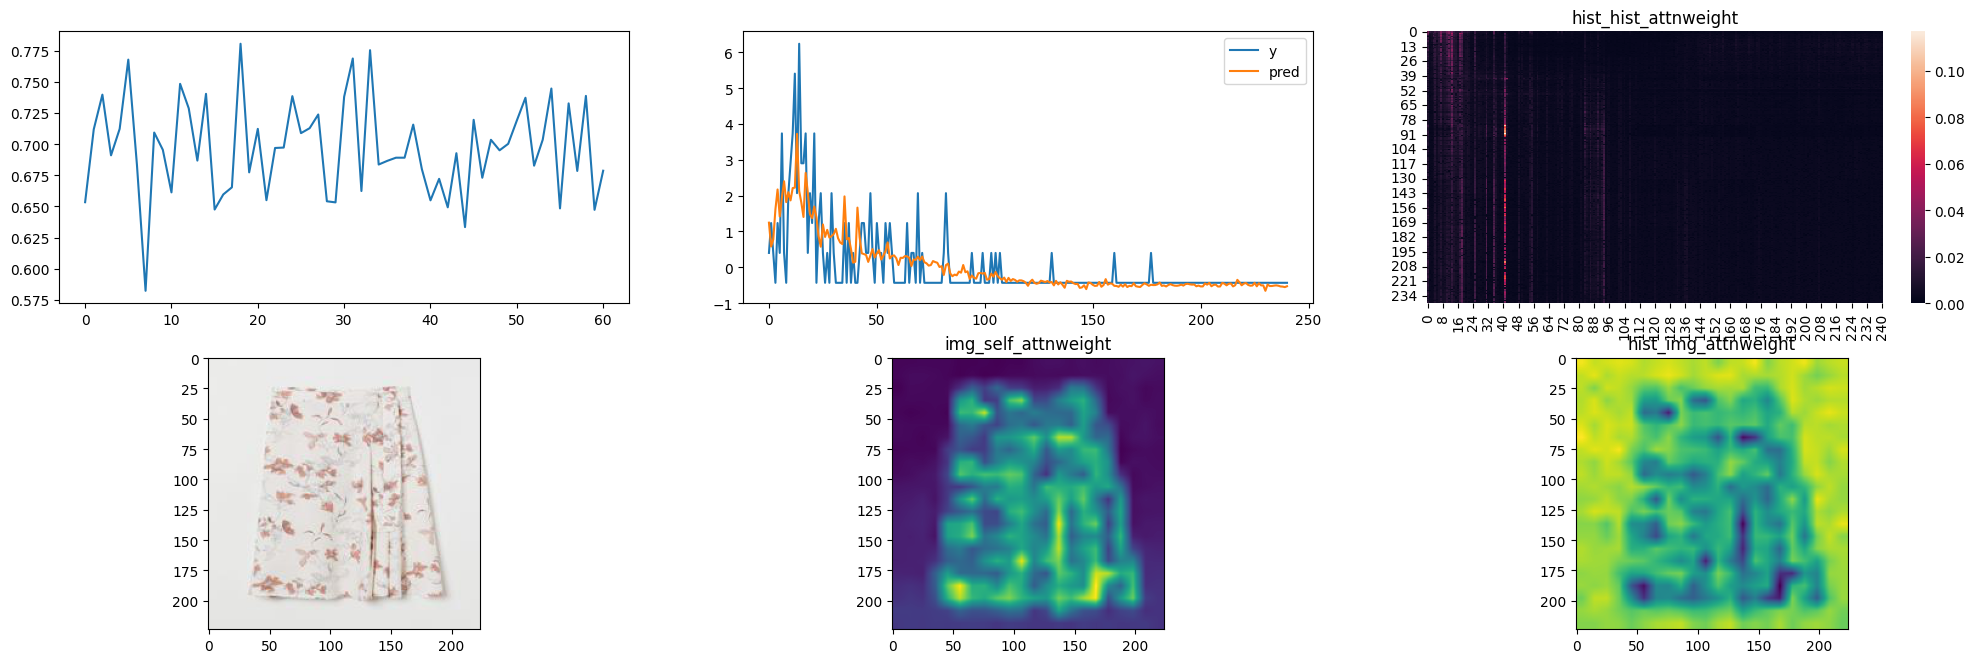

1 - loss: 0.6955264687538147, lr: 0.00098:   6%|▌         | 65/1173 [00:39<11:16,  1.64it/s]


KeyboardInterrupt: 

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
mse_loss = torch.nn.MSELoss(reduction="none")

def loss_fn(pred, y, mask):
    mask = torch.where((mask==fake_mask_val), 1, 0)
    loss = mse_loss(pred, y)
    loss = mask * loss
    loss = loss.sum()/mask.sum()
    return loss

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li = []
    window = 100

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        pred, hist_hist_attnweight, hist_static_attnweight, hist_img_attnweight, img_self_attnweight = model(
                                data["sales"].to(device),
                                data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                                data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
                                data["img_input"].to(device),
                                data["mask"].to(device),
                                )
        loss = loss_fn(pred, data["y"].to(device), data["mask"].to(device))
        loss.backward()
        optimizer.step()

        loss_li.append(loss.item())
        pbar.set_description(f"{e} - loss: {np.mean(loss_li[-window:])}, lr: {optimizer.param_groups[0]['lr']}")

        if n % 20 == 0:
            idx = 0
            plt.figure(figsize=(25,12))
            nrows, ncols = 3, 3
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(loss_li[-window:])

            # Sample
            length = data["length"][idx]
            plt.subplot(nrows, ncols, 2)
            plt.plot(data["y"][idx][:length], label="y")
            plt.plot(pred[idx][:length].detach().cpu(), label="pred")
            plt.legend()

            # Attn
            plt.subplot(nrows, ncols, 3)
            sns.heatmap(hist_hist_attnweight[idx][:length, :length].detach().cpu())
            plt.title("hist_hist_attnweight")

            plt.subplot(nrows, ncols, 4)
            plt.imshow(data["img_raw"][idx])

            plt.subplot(nrows, ncols, 5)
            img_self_attnweight = img_self_attnweight.min(dim=1).values
            mask = img_self_attnweight[idx, 0, 1:].reshape(22,22).cpu().detach().numpy() # 28,28 or 14,14
            mask = cv2.resize(mask / mask.max(), data["img_raw"][idx].size)[..., np.newaxis]
            plt.title("img_self_attnweight")
            plt.imshow(mask)

            plt.subplot(nrows, ncols, 6)
            hist_img_attnweight = hist_img_attnweight.mean(dim=1)
            mask = hist_img_attnweight[idx, 1:].reshape(22,22).cpu().detach().numpy() # 28,28 or 14,14
            mask = cv2.resize(mask / mask.max(), data["img_raw"][idx].size)[..., np.newaxis]
            plt.title("hist_img_attnweight")
            plt.imshow(mask)

            hist_static_attnweight = hist_static_attnweight.mean(dim=1)[idx].detach().cpu()
            hist_static_attnweight = pd.DataFrame(hist_static_attnweight).reset_index()

            def func(x):
                if x == 0: 
                    mapper = train_dataset.index_encoder.mapper
                    val = data["index_name"][idx].numpy()[0]
                elif x == 1: 
                    mapper = train_dataset.color_encoder.mapper
                    val = data["colour_group_name"][idx].numpy()[0]
                elif x == 2: 
                    mapper = train_dataset.graphic_encoder.mapper
                    val = data["graphical_appearance_name"][idx].numpy()[0]
                elif x == 3: 
                    mapper = train_dataset.product_encoder.mapper
                    val = data["product_type_name"][idx].numpy()[0]
            
                mapper = {value:key for key, value in mapper.items()}
                return mapper[val]

            hist_static_attnweight["index"] = hist_static_attnweight["index"].apply(func)
            hist_static_attnweight["cat"] = ["index_name", "color", "graphic", "product_type"]
            hist_static_attnweight = hist_static_attnweight[["cat", "index", 0]]
            hist_static_attnweight = hist_static_attnweight.sort_values(0, ascending=False)
            display(hist_static_attnweight)

            plt.show()

epoch = 5
for e in range(epoch):
    train(e)
    scheduler.step()

# Eval

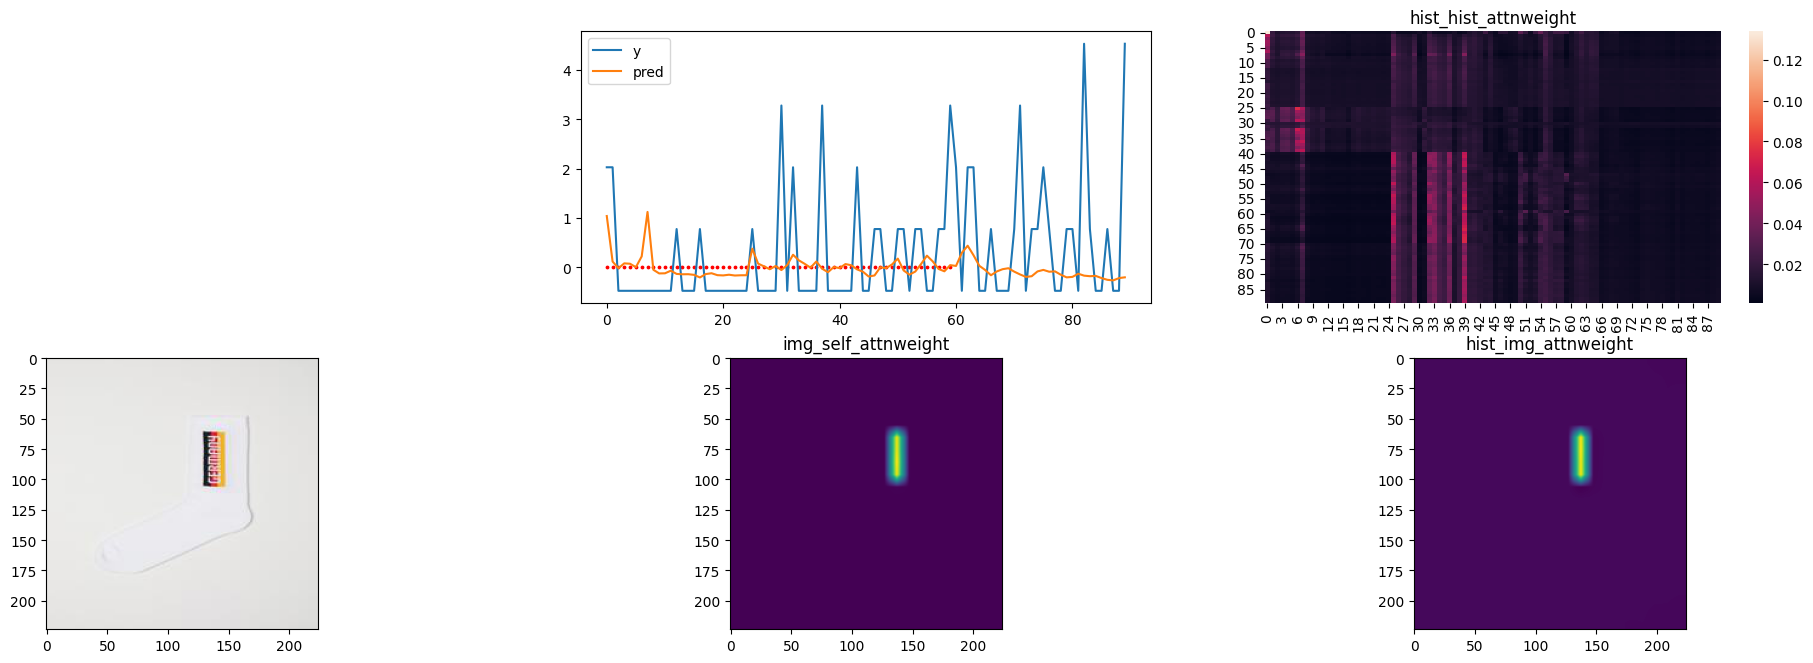

In [12]:
model.eval()
pbar = tqdm(valid_dataloader)

for n, data in enumerate(pbar):
    with torch.no_grad():
        sales = data["sales"].to(device)
        mask = data["mask"].to(device)
        pred, hist_hist_attnweight, hist_static_attnweight, hist_img_attnweight, img_self_attnweight = model(
                                data["sales"].to(device), 
                                data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                                data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
                                data["img_input"].to(device),
                                data["mask"].to(device),
                                )

        # for i in range(30):
        #     pred, hist_hist_attnweight, hist_static_attnweight, hist_img_attnweight, img_self_attnweight = model(
        #                             sales, 
        #                             data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
        #                             data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
        #                             data["img_input"].to(device),
        #                             data["mask"].to(device),
        #                             )
        #     idx = torch.argmin(sales, -1)
        #     for n, i in enumerate(idx):
        #         sales[n, i] = pred[n, i]
        #         mask[n, i] = real_mask_val
        
        # idx = 0
        idx = data["y"][:, -1]
        idx = torch.argmax(idx)
        plt.figure(figsize=(25,12))
        nrows, ncols = 3, 3
        clear_output(wait=True)

        # Sample
        length = data["length"][idx]
        plt.subplot(nrows, ncols, 2)
        plt.plot(data["y"][idx][:length], label="y")
        plt.plot(pred[idx][:length].detach().cpu(), label="pred")
        plt.scatter(np.arange(data["mask"][idx][:length].shape[0]), torch.where(data["mask"][idx]==1, 0, np.nan)[:length], color="red", s=3)
        plt.legend()

        # Attn
        plt.subplot(nrows, ncols, 3)
        sns.heatmap(hist_hist_attnweight[idx][:length, :length].detach().cpu())
        plt.title("hist_hist_attnweight")

        plt.subplot(nrows, ncols, 4)
        plt.imshow(data["img_raw"][idx])

        plt.subplot(nrows, ncols, 5)
        img_self_attnweight = img_self_attnweight.mean(dim=1)
        mask = img_self_attnweight[idx, 0, 1:].reshape(22,22).cpu().detach().numpy() # 28,28 or 14,14
        mask = cv2.resize(mask / mask.max(), data["img_raw"][idx].size)[..., np.newaxis]
        plt.title("img_self_attnweight")
        plt.imshow(mask)

        plt.subplot(nrows, ncols, 6)
        mask = hist_img_attnweight[idx, 0, 1:].reshape(22,22).cpu().detach().numpy() # 28,28 or 14,14
        mask = cv2.resize(mask / mask.max(), data["img_raw"][idx].size)[..., np.newaxis]
        plt.title("hist_img_attnweight")
        plt.imshow(mask)

        plt.show()
        input()